# Bayesian Autoregression with `pymc`

Let's take the most trivial autoregressive model, the AR(1), expressed in a typical linear regression fashion with an intercept term and additive error:

$$
\begin{aligned}
X_t &= \alpha + \phi_1 X_{t-1} + \epsilon_t \\
\epsilon_t &\sim \text{iid } \mathcal{N}(0, \sigma^2)
\end{aligned}
$$

Where $X_t$ is the data at time $t$, $\alpha$ is a constant term and $\phi$ is the parameter we would like to estimate from data, and $\epsilon_t$ is a noise parameter.

We'll start with generating a simple dataset where the true values are:

$$
X_t = 10 + 0.76X_{t-1} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0,1)
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# True parameters
n = 30
intercept = 10
true_beta = 0.76
true_sigma = 1 # for completeness

# Generate Data
X = np.ones(n)
X[0] = intercept
# Grow the data from the initial value
for i in range(1, n):
    X[i] = intercept + (true_beta * X[i-1])
X = X + np.random.normal(loc=0, scale=true_sigma, size=n)
X = pd.Series(X, name="X_obs")

# Create a dataframe with one column with values and the lag(1) values
df = pd.DataFrame({"X_obs":X, "X_lag":X.shift(1)})

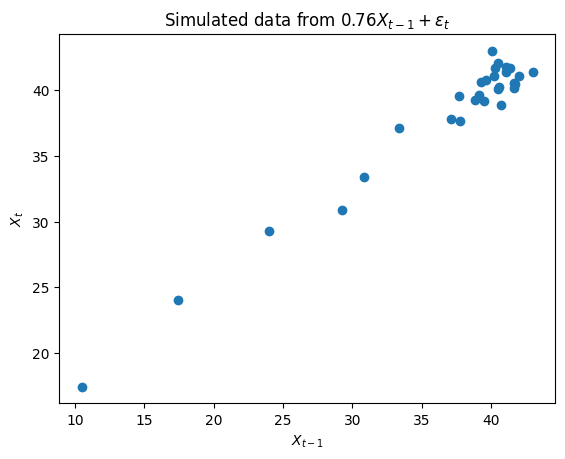

In [2]:
# Plot the simulated data
p = plt.scatter(df.X_lag, df.X_obs)
plt.title("Simulated data from $0.76 X_{t-1} + \epsilon_t$")
plt.xlabel("$X_{t-1}$")
plt.ylabel("$X_t$");

## Statsmodels

Statsmodels has an `AutoReg` autoregressive model right off the bat:

In [62]:
# Statsmodels
from statsmodels.tsa.ar_model import AutoReg
# from statsmodels.tsa.arima.model import ARIMA

# Instantiate model 
mod = AutoReg(df.X_obs, 1, old_names=False)
# mod = ARIMA(df.X_obs, order=(1,0,0))

# Fit and display results
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  X_obs   No. Observations:                   30
Model:                     AutoReg(1)   Log Likelihood                 -42.909
Method:               Conditional MLE   S.D. of innovations              1.063
Date:                Thu, 06 Apr 2023   AIC                             91.817
Time:                        21:22:11   BIC                             95.919
Sample:                             1   HQIC                            93.102
                                   30                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6347      0.986     10.789      0.000       8.703      12.567
X_obs.L1       0.7409      0.026     28.334      0.000       0.690       0.792
                                    Roots           

The model performs quite nicely, getting close to the true values for the intercept and the slope.

## `nixtla` StatsForecast

The `StatsForecast` library from `nixtla` offers a lot of advantages when doing forecasting at scale, with lots of functionality for practical time series analysis (like dealing with hierarchical data, for instance).

`StatsForecast` likes long dataframes with 3 columns: a `unique_id`, `ds` for datestamp, and `y` for values.

In [64]:
from statsforecast import StatsForecast
from statsforecast.models import AutoRegressive, AutoARIMA
from datasetsforecast.losses import mape

# Following the convention in the quickstart that's flexible for multiple models
sf = StatsForecast(
    models = [AutoRegressive(lags=1), AutoARIMA()],
    freq='M'
)

# Convert the data to a long dataframe format with 3 columns: unique_id, ds, y
daterange = pd.date_range(start="1/1/2021", periods=n, freq='M')
df2 = pd.DataFrame({"unique_id":"X", "ds":daterange, "y":df.X_obs})

df2.head()

# sf.predict(h=12, level=[95])
sf.fit(df2)

StatsForecast(models=[AutoRegressive,AutoARIMA])

Built in Plotting helpers, with default plotly backend:

In [65]:
StatsForecast.plot(df2)

In [66]:
crossvaldation_df = sf.cross_validation(
    df=df2,
    h=4,
    step_size=20,
    n_windows=1
  )

In [67]:
crossvaldation_df

,ds,cutoff,y,AutoRegressive,AutoARIMA
unique_id,,,,,
X,2023-03-31,2023-02-28,40.490452,41.679375,42.133125
X,2023-04-30,2023-02-28,42.023197,41.615147,42.521851
X,2023-05-31,2023-02-28,41.051460,41.551712,42.910572
X,2023-06-30,2023-02-28,41.363903,41.489056,43.299297


Error metrics:

In [68]:
mape(crossvaldation_df['y'], crossvaldation_df['AutoRegressive'])

1.3571196235716343

## Bayesian AutoRegression with `pymc`

Bayesian Inference is super flexible and is well suited for this example. As a bonus we'll get distributions around the unknown slope and intercept parameter.

We first start by restructuring the original AR equation using matrix notation.

We originally stated the AR(1) model as:

$$
\begin{aligned}
X_t &= \alpha + \phi_1 X_{t-1} + \epsilon_t \\
\epsilon_t &\sim \text{iid } \mathcal{N}(0, \sigma^2)
\end{aligned}
$$


In [23]:
import arviz as az
import pymc as pm

print(f"Running PyMC v{pm.__version__}")
az.style.use("arviz-darkgrid")

Running PyMC v5.2.0


### The model

In order to estimate the unknown slope parameter, we must further specify prior distributions for some of the other unknowns like the intercept and the $\epsilon$ noise term.

**Priors:**

$$
\begin{aligned}
\alpha &\sim N(8,2) \\
\phi_1 &\sim N(0,2) \\
\sigma &\sim \operatorname{HalfNormal}(0,1)
\end{aligned}
$$

**Likelihood:**

The probability of seeing this data given the parameters

$$
x_t|\phi_1, \sigma, \alpha, x_{t-1} \sim N(\phi_1 x_{t-1}, \sigma)
$$

**Posterior**

The posterior distribution is proportional to the Priors $\times$ the Likelihood

$$
\phi_1, \sigma, \alpha | x \sim ?
$$

In [69]:
# Example using pure pymc
ar_model = pm.Model()

with ar_model:
    alpha = pm.Normal('intercept', mu=8, sigma=2)
    epsilon = pm.HalfNormal("epsilon", sigma=1)
    beta = pm.Normal("slope", mu=0, sigma=1)

    # Expected value of the outcome
    mu = alpha + beta * df.X_lag[1:20]

    # # Likelihood
    # likelihood = pm.AR("x", beta, epsilon, observed=df.X_obs[1:20])

    # If we didn't use the pm.AR, this is what we would be left with
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=df.X_obs[1:20])

    idata=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, epsilon, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


### Posterior Analysis:

`Arviz` gives us plotting and diagnostics functions. 

Here's `az.summary()`:

In [70]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,10.11,0.92,8.39,11.87,0.02,0.02,1607.24,1388.14,1.0
slope,0.75,0.03,0.70,0.80,0.00,0.00,1601.14,1451.11,1.0
epsilon,1.07,0.19,0.76,1.40,0.00,0.00,1569.78,1387.31,1.0


And the result is a model that gets us fairly close to the true values but with the added benefit of providing us with posterior distributions of each of the unknown parameters.

Next is `az.plot_trace()`:

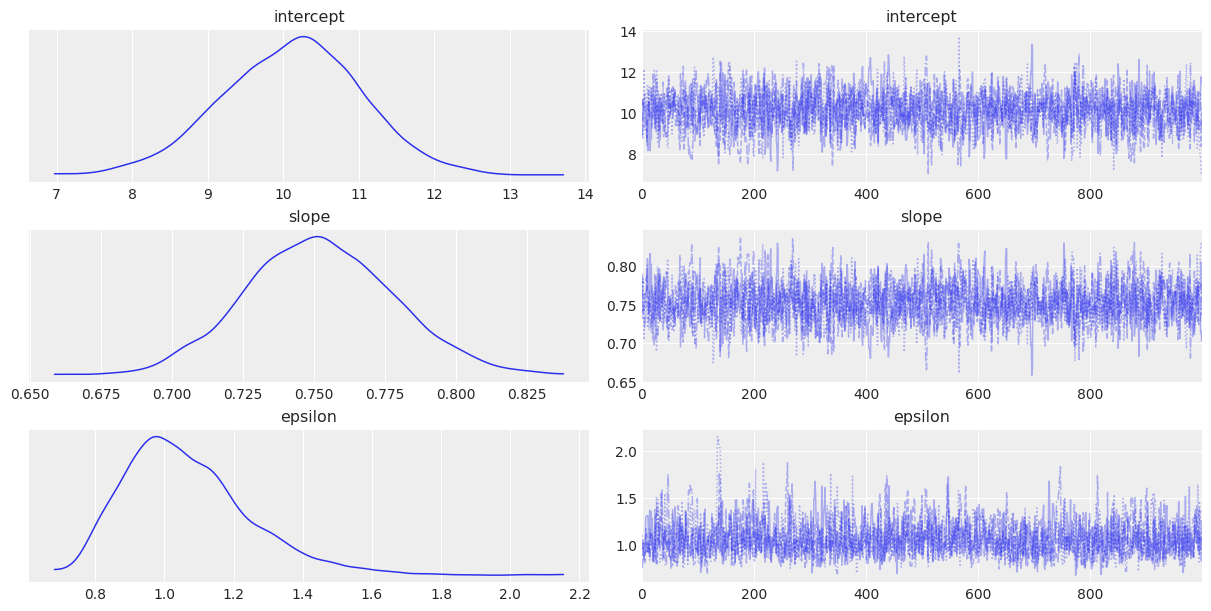

In [71]:
az.plot_trace(idata, combined=True);

On the left we have the posterior distributions and the right are the samples from the markov chain. 

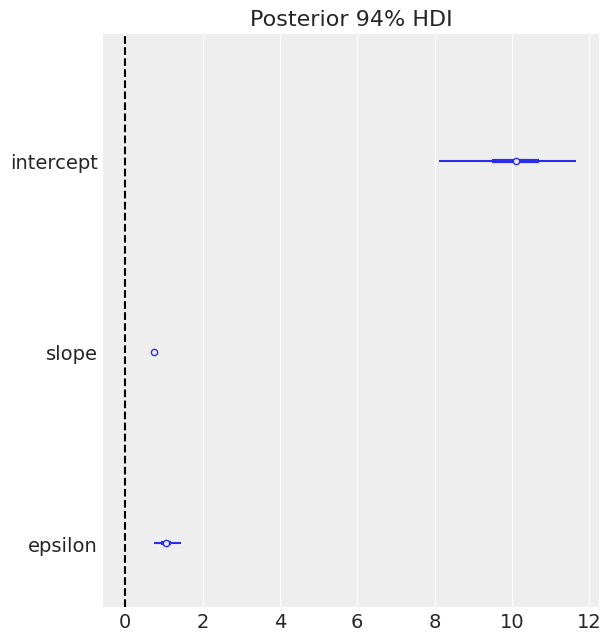

In [44]:
az.plot_forest(idata, combined=True)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI");

## `pymc` with `pm.AR`

`pymc` also includes an `AR` distribution that we can use:

Reference: 
* [Example](https://www.pymc.io/projects/examples/en/latest/time_series/AR.html)
* [pymc docs](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.AR.html)

Restating $\alpha$ as $\phi_0$, we can see that this simplifies with matrix notation:

$$
\begin{aligned}
X_t &= \phi_0 + \phi_1 X_{t-1} + \epsilon_t, \quad \epsilon_t \sim \text{iid } \mathcal{N}(0, \sigma^2) \\
& \rightarrow X_{t-1}\Phi + \epsilon_t
\end{aligned}
$$

In [72]:
# Create an AR of order 1, with a constant term

with pm.Model() as ar1:
    # assumes 95% of prob mass is between -2 and 2
    rho = pm.Normal("rho", mu=0.0, sigma=2.0, shape=2)
    print(rho.shape)
    # # precision of the innovation term
    # tau = pm.Exponential("tau", lam=0.5)

    sigma = pm.HalfNormal("sigma", 1)

    likelihood = pm.AR("y", rho=rho, sigma=sigma, constant=True, 
                       init_dist=pm.Normal.dist(0, 10), observed=df.X_obs)

    ardata = pm.sample(1000, tune=2000, random_seed=42)

TensorConstant{(1,) of 2}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 27 seconds.


Just like before, we check out the summary:

In [59]:
az.summary(ardata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],7.914,1.200,5.676,10.026,0.040,0.028,926.0,1086.0,1.0
rho[1],0.812,0.032,0.758,0.874,0.001,0.001,927.0,1260.0,1.0
sigma,1.256,0.203,0.898,1.655,0.006,0.004,1021.0,969.0,1.0


Not as great - We could probably do better with separating out the `rho` terms so we can set different priors, but would need to better understand pytorch tensors and `TensorVariable`s. Setting that as a TODO for now.

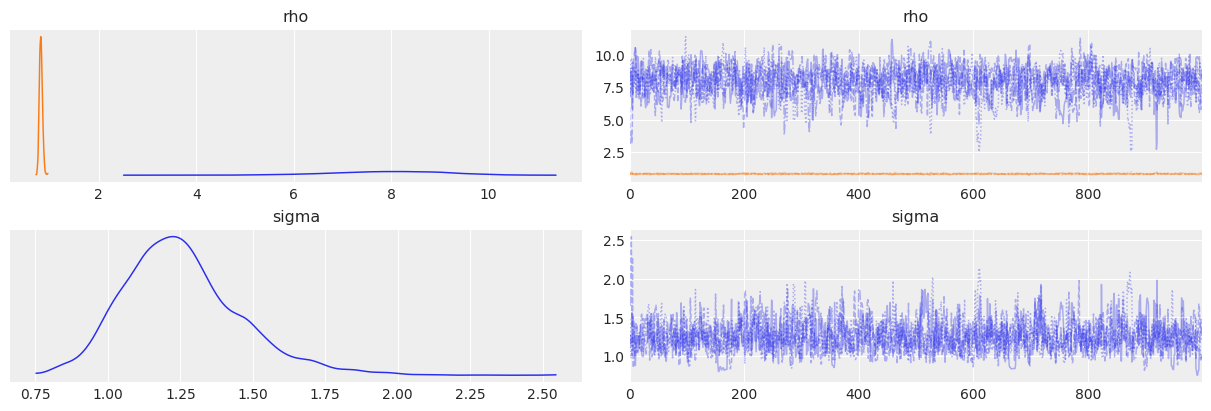

In [60]:
az.plot_trace(ardata, combined=True);

## State Space Representation

Reference: 

* [State Space Models and the Kalman Filter](http://faculty.washington.edu/ezivot/econ584/notes/statespacemodels.pdf)
* [this stackexchange question](https://dsp.stackexchange.com/questions/2197/different-state-space-representations-for-auto-regression-and-kalman-filter)

In the AR(1) model, the states of the system are the current ($X_t$) and previous values ($X_{t-1}$) of the output.

$$
\begin{aligned}
X_t &= \mu + c_t \\
c_t &= \phi_1 c_{t-1} + \eta_t
\end{aligned}
$$

Where the unobserved state vector is $(c_t, c_{t-1})'$